# TDM MIMO FMCW Radar

This is a time-division-multiplexing (TDM) multiple-input and multiple-output (MIMO) FMCW radar simulation example based on `RadarSimPy`.

>`RadarSimPy` is a radar simulation package built with python. **<a href="https://zpeng.me/#contact" target="_blank">Contact me</a> if you are interested in this module.**

This notebook is available on my <a href="https://github.com/rookiepeng/radar-simulation-notebooks" target="_blank">GitHub</a>.


## Radar Model
### Transmitters

For TDM configuration, `time_offset` parameter controls the time offset between transmitter channels. `time_offset` can be a single number, which means the next transmiter channel is delayed by the same time. `time_offset` can also be an array. The length of the array must be the same as the channel number.

The following tables list the basic parameters of the 4-channel radar transmitter. **(The number of channels is determined by the size of transmitter array)**

#### Tx Channel 1

| Parameter                       | Variable in `RadarSimPy` | Value      |
|---------------------------------|--------------------------|------------|
| Center frequency ($f_c$)        | fc                       | 24.125 GHz |
| Bandwidth ($B$)                 | bandwidth                | 100 MHz    |
| Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
| Rising or falling chirp         | slop_type                | rising     |
| Chirp repetition period ($CRP$) | repetition_period        | 400 us     |
| Chirp length ($T$)              | pulse_length             | 80 us      |
| Number of chirps                | pulse_counts             | 256        |
| Chirp start delay               | delay                    | 0 s        |
| Channel transmit time offset    | time_offset              | **0 s**    |


#### Tx Channel 2

| Parameter                       | Variable in `RadarSimPy` | Value      |
|---------------------------------|--------------------------|------------|
| Center frequency ($f_c$)        | fc                       | 24.125 GHz |
| Bandwidth ($B$)                 | bandwidth                | 100 MHz    |
| Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
| Rising or falling chirp         | slop_type                | rising     |
| Chirp repetition period ($CRP$) | repetition_period        | 400 us     |
| Chirp length ($T$)              | pulse_length             | 80 us      |
| Number of chirps                | pulse_counts             | 256        |
| Chirp start delay               | delay                    | 0 s        |
| Channel transmit time offset    | time_offset              | **100 us** |

#### Tx Channel 3

| Parameter                       | Variable in `RadarSimPy` | Value      |
|---------------------------------|--------------------------|------------|
| Center frequency ($f_c$)        | fc                       | 24.125 GHz |
| Bandwidth ($B$)                 | bandwidth                | 100 MHz    |
| Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
| Rising or falling chirp         | slop_type                | rising     |
| Chirp repetition period ($CRP$) | repetition_period        | 400 us     |
| Chirp length ($T$)              | pulse_length             | 80 us      |
| Number of chirps                | pulse_counts             | 256        |
| Chirp start delay               | delay                    | 0 s        |
| Channel transmit time offset    | time_offset              | **200 us** |

#### Tx Channel 4

| Parameter                       | Variable in `RadarSimPy` | Value      |
|---------------------------------|--------------------------|------------|
| Center frequency ($f_c$)        | fc                       | 24.125 GHz |
| Bandwidth ($B$)                 | bandwidth                | 100 MHz    |
| Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
| Rising or falling chirp         | slop_type                | rising     |
| Chirp repetition period ($CRP$) | repetition_period        | 400 us     |
| Chirp length ($T$)              | pulse_length             | 80 us      |
| Number of chirps                | pulse_counts             | 256        |
| Chirp start delay               | delay                    | 0 s        |
| Channel transmit time offset    | time_offset              | **300 us** |


The transmitter array consists of 4 antenna elements with a $2\lambda$ spacing. Both of the transmitter antenna elements have the same radiation pattern $\cos{\theta}$. The gain of the transmitter antenna elements is 6 dB.

In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

wavelength = 3e8 / 24.125e9

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

tx_channel_1 = dict(location=(0, -12 * wavelength, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=0)
tx_channel_2 = dict(location=(0, -8 * wavelength, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=100e-6)
tx_channel_3 = dict(location=(0, -4 * wavelength, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=200e-6)
tx_channel_4 = dict(location=(0, 0, 0),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=300e-6)

tx = Transmitter(f=[24.075e9, 24.175e9],
                 pulse_time=80e-6,
                 tx_power=15,
                 repetition_period=400e-6,
                 pulses=1,
                 channels=[tx_channel_1, tx_channel_2, tx_channel_3, tx_channel_4])

### Receiver
The parameters of the receiver are listed in the table below.

| Parameter                        | Variable in RaSim | Value        |
|----------------------------------|-------------------|--------------|
| Sampling rate ($f_s$)            | fs                | 2 Msps       |
| Noise figure ($NF$)              | noise_figure      | 12 dB        |
| RF gain/loss ($G_{rf}$)          | rf_gain           | 20 dB        |
| Load resistor ($R_L$)            | load_resistor     | 500 $\Omega$ |
| Baseband voltage gain ($G_{BB}$) | baseband_gain     | 30 dB        |

The receiver array consists of 8 antenna elements with a $\lambda /2$ spacing. All of the receiver antenna elements have the same radiation pattern $\cos{\theta}$. The gain of the receiver antenna elements is 6 dB.

In [2]:
channels = []
for idx in range(0, 8):
    channels.append(
        dict(
            location=(0, wavelength / 2 * idx, 0),
            azimuth_angle=angle,
            azimuth_pattern=pattern,
            elevation_angle=angle,
            elevation_pattern=pattern,
        ))
    
rx = Receiver(fs=2e6,
              noise_figure=8,
              rf_gain=20,
              baseband_gain=50,
              load_resistor=500,
              channels=channels)

Create the FMCW radar model based on all the parameters defined above.

In [3]:
radar = Radar(transmitter=tx, receiver=rx)

Calculate the characteristics of the FMCW radar:

- Total channels: $$N_{Total}=N_{TX} \times N_{RX}$$

- Maximum range (*with I/Q baseband*): $$R_{max}=\frac{c f_s T}{2B}$$

- Maximum range (*without I/Q baseband*): $$R_{max}=\frac{c f_s T}{4B}$$

- Unambiguous velocity: $$v_{ua}=\frac{c}{2 CRP \times f_c}$$ or $$v_{ua}=\pm \frac{c}{4 CRP \times f_c}$$

- Range resolution: $$\delta_r=\frac{c}{2B}$$


In [4]:
print('Total channels: ', radar.channel_size)
print('Maximum range: ', radar.max_range, ' m')
print('Maximum unambiguous speed: ', radar.unambiguous_speed, ' m/s')
print('Range_resolution: ', radar.range_resolution, ' m')

Total channels:  32
Maximum range:  239.83396640000004  m
Maximum unambiguous speed:  15.533287979274611  m/s
Range_resolution:  1.49896229  m


### Targets
The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (radian).

In [5]:
target_1 = dict(location=(160, 0, 0), speed=(0, 0, 0), rcs=25, phase=0)
target_2 = dict(location=(80, -80, 0), speed=(0, 0, 0), rcs=20, phase=0)
target_3 = dict(location=(30, 20, 0), speed=(0, 0, 0), rcs=8, phase=0)

targets = [target_1, target_2, target_3]

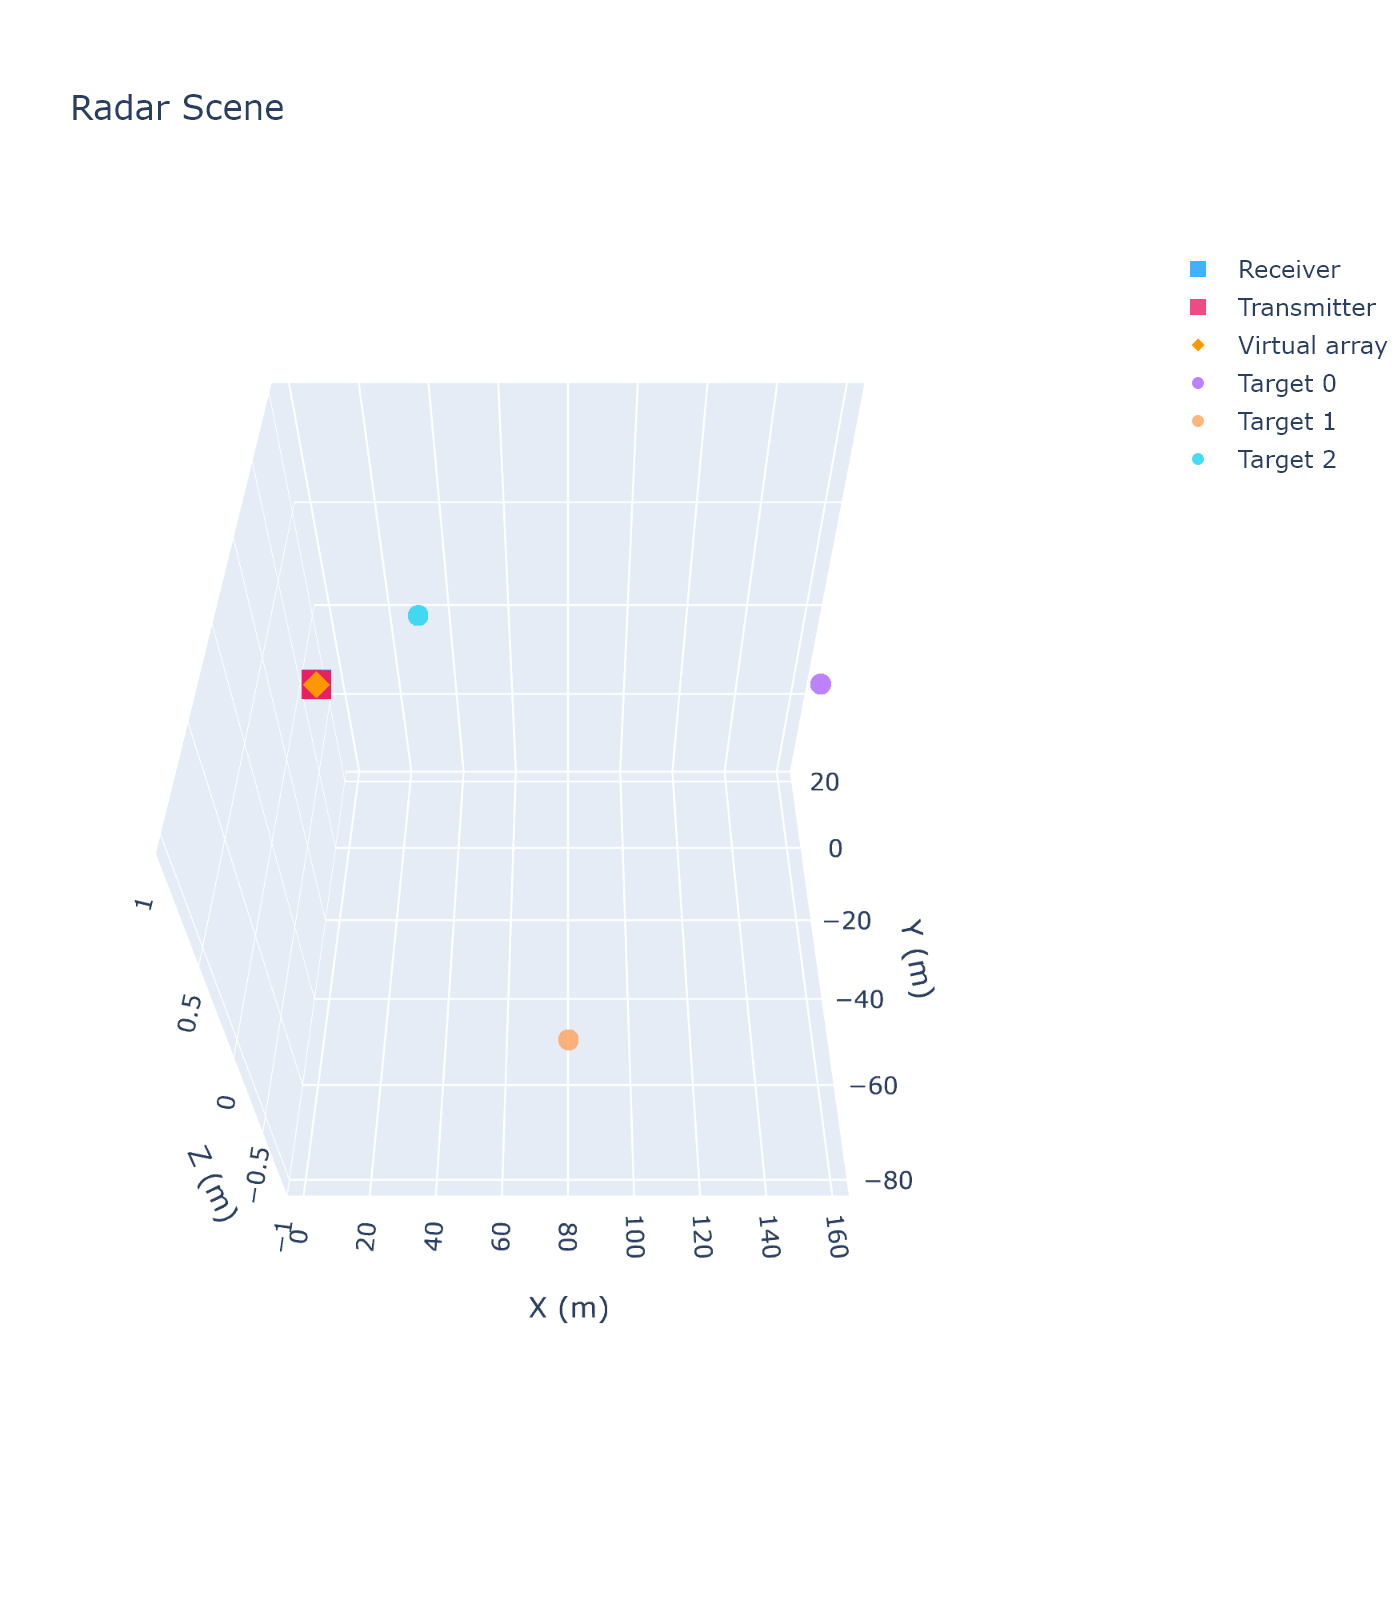

In [6]:
import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.display import Image

rx_locations = radar.receiver.locations
tx_locations = radar.transmitter.locations
virtual_array = radar.virtual_array

rx_axis = go.Scatter3d(
    x=rx_locations[:, 0],
    y=rx_locations[:, 1],
    z=rx_locations[:, 2],
    mode='markers',
    name='Receiver',
    marker=dict(color='rgb(17, 157, 255)',
                size=8,
                opacity=0.8,
                symbol='square'),
)

tx_axis = go.Scatter3d(
    x=tx_locations[:, 0],
    y=tx_locations[:, 1],
    z=tx_locations[:, 2],
    mode='markers',
    name='Transmitter',
    marker=dict(color='rgb(233, 30, 99)', size=8, opacity=0.8,
                symbol='square'),
)

virtual_axis = go.Scatter3d(
    x=virtual_array[:, 0],
    y=virtual_array[:, 1],
    z=virtual_array[:, 2],
    mode='markers',
    name='Virtual array',
    marker=dict(color='rgb(255, 152, 0)', size=5, opacity=1, symbol='diamond'),
)

data = [rx_axis, tx_axis, virtual_axis]

for target_idx, target in enumerate(targets):
    target_loc = go.Scatter3d(
        x=[target['location'][0]],
        y=[target['location'][1]],
        z=[target['location'][2]],
        mode='markers',
        name='Target ' + str(target_idx),
        marker=dict(size=6, opacity=0.8),
    )
    data = data + [target_loc]

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=-1.5, z=1.8),
)

layout = go.Layout(
    title='Radar Scene',
    height=800,
    scene=dict(
        xaxis=dict(title='X (m)'),
        yaxis=dict(title='Y (m)'),
        zaxis=dict(title='Z (m)'),
        camera=camera,
        aspectmode='cube',
    ),
    margin=dict(l=0, r=0, b=120, t=120),
)
fig = go.Figure(data=data, layout=layout)
# iplot(fig)
Image(fig.to_image(format='png', scale=2), retina=True)

## Simulate Baseband Signals

Calculate baseband signal matrix:
$$[channel, slow~time, fast~time]$$

In [7]:
from radarsimpy import simulator as sim

data = sim(radar, targets)
timestamp = data['timestamp']
baseband = data['baseband']

In [8]:
from radarsimpy import simulatorcpp as simcpp

data = simcpp(radar, targets)
timestamp = data['timestamp']
baseband = data['baseband']

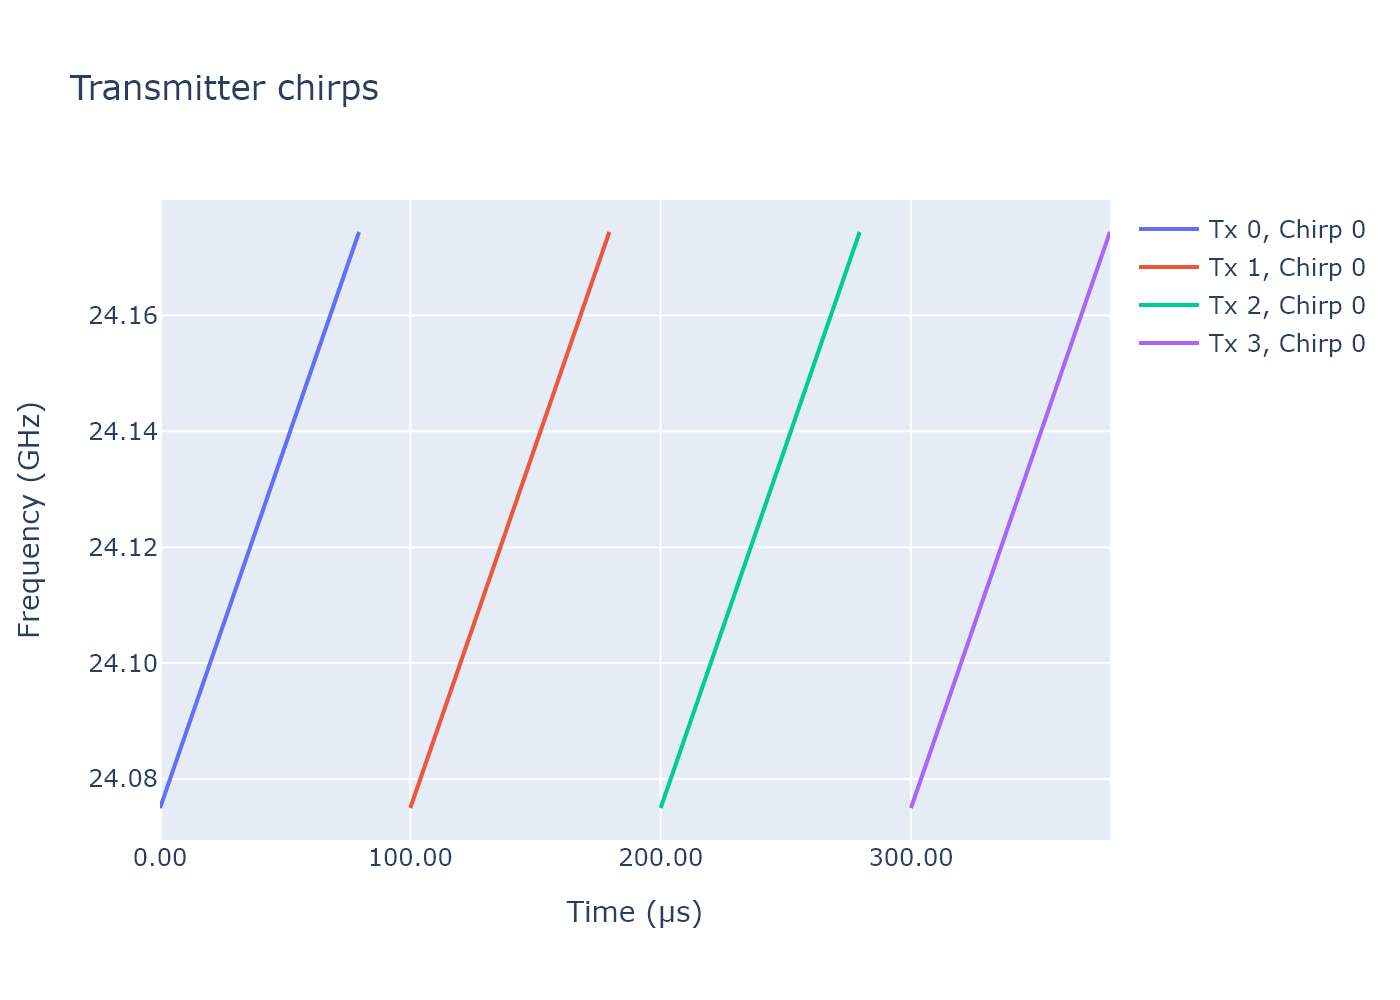

In [10]:
data = []
for idx in range(0, 1):
    for ch_idx in range(0, 32, 8):
        chirp = go.Scatter(
            x=timestamp[ch_idx, idx, :] * 1e6,
            y=np.linspace(
                radar.transmitter.fc_0 - radar.transmitter.bandwidth / 2,
                radar.transmitter.fc_0 + radar.transmitter.bandwidth / 2,
                radar.samples_per_pulse,
                endpoint=False,
            ) / 1e9,
            name='Tx ' + str(int(ch_idx / 8)) + ', Chirp ' + str(idx),
        )
        data = data + [chirp]

layout = go.Layout(
    title='Transmitter chirps',
    yaxis=dict(tickformat='.2f', title='Frequency (GHz)'),
    xaxis=dict(tickformat='.2f', title='Time (µs)'),
)

fig = go.Figure(data, layout=layout)
# iplot(fig)
Image(fig.to_image(format='png', scale=2), retina=True)

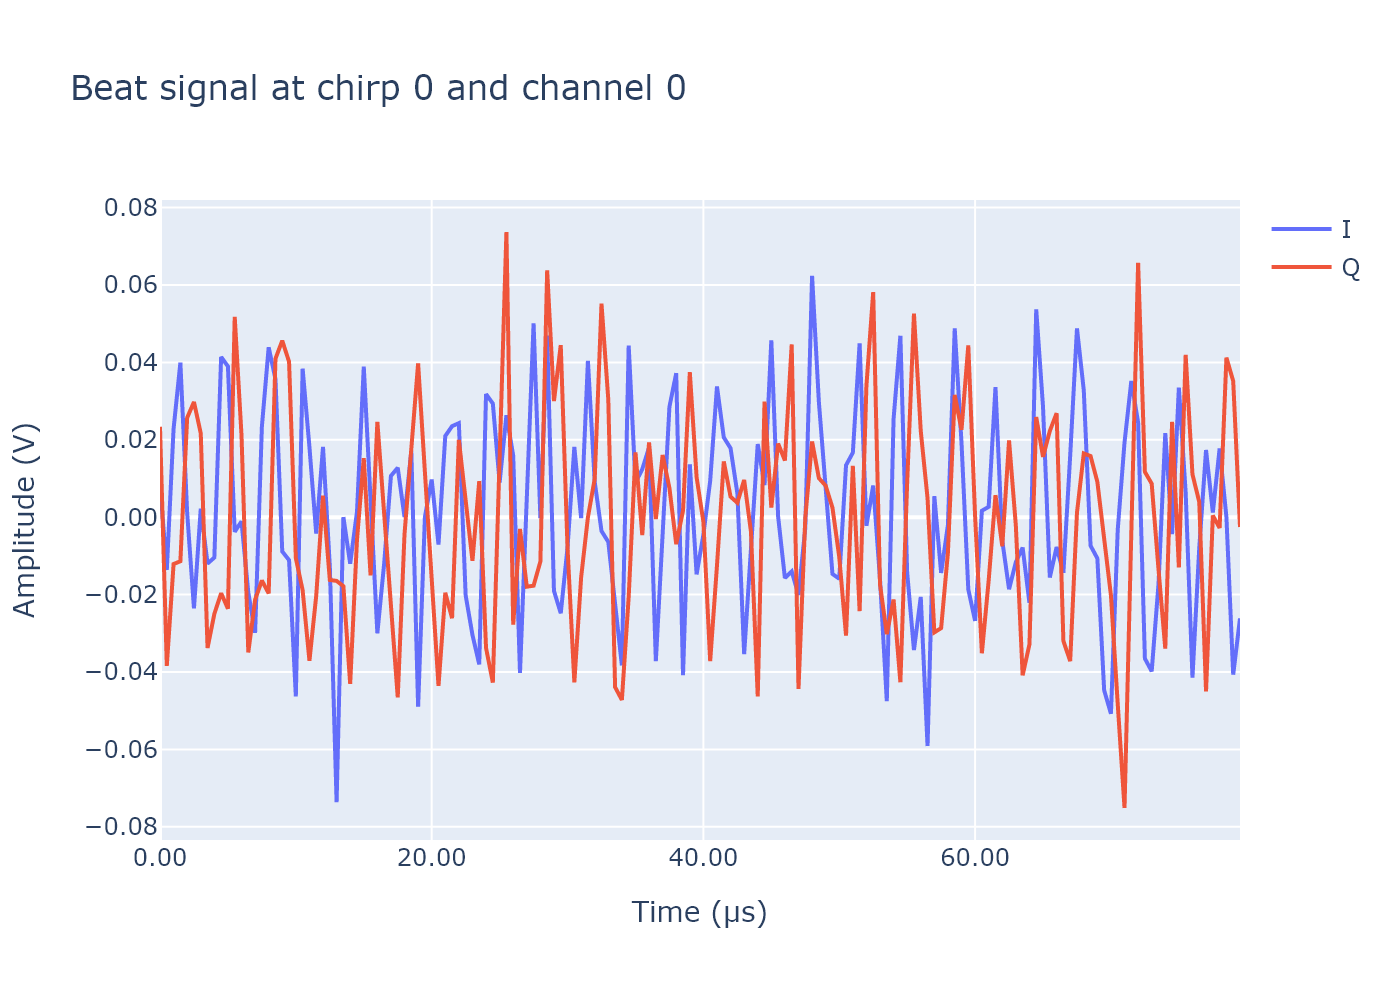

In [11]:
beat_I = go.Scatter(
    x=timestamp[0, 0, :] * 1e6,
    y=np.real(baseband[0, 0, :]),
    name='I',
)
beat_Q = go.Scatter(
    x=timestamp[0, 0, :] * 1e6,
    y=np.imag(baseband[0, 0, :]),
    name='Q',
)
data = [beat_I, beat_Q]

layout = go.Layout(
    title='Beat signal at chirp 0 and channel 0',
    yaxis=dict(tickformat='.2f', title='Amplitude (V)'),
    xaxis=dict(tickformat='.2f', title='Time (µs)'),
)

fig = go.Figure(data, layout=layout)
# iplot(fig)
Image(fig.to_image(format='png', scale=2), retina=True)

## Radar Signal Processing
### Range profile

In [12]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, baseband, range_window)

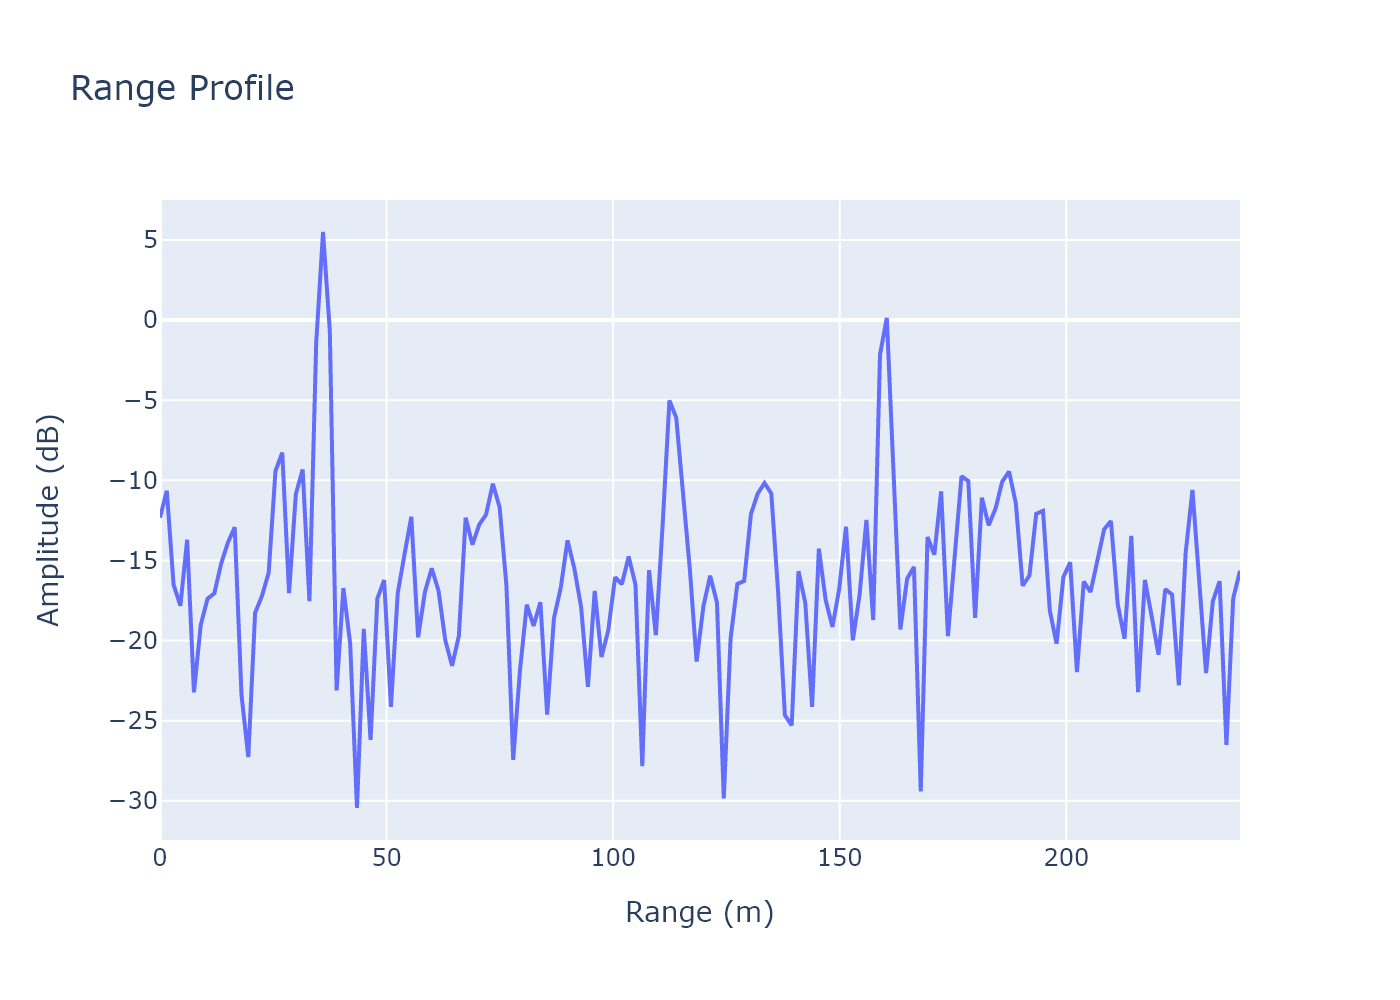

In [13]:
temp = np.abs(range_profile[0, :, :])
temp = 20 * np.log10(temp + 0.001)

range_axis = np.linspace(
    0, radar.max_range, radar.samples_per_pulse, endpoint=False)

doppler_axis = np.linspace(
    0, radar.transmitter.pulses, radar.transmitter.pulses, endpoint=False)

data = [go.Scatter(x=range_axis, y=temp[0, :])]

layout = go.Layout(
    title='Range Profile',
    xaxis=dict(title='Range (m)'),
    yaxis=dict(title='Amplitude (dB)'),
)

fig = go.Figure(data=data, layout=layout)
# iplot(fig)
Image(fig.to_image(format='png', scale=2), retina=True)

### Digital Beamforming

In [17]:
azimuth = np.arange(-90, 90, 1)

array_loc_x = np.zeros((1, len(radar.virtual_array)))
for va_idx, va in enumerate(radar.virtual_array):
    array_loc_x[0, va_idx] = va[1] * radar.transmitter.fc_0 / 3e8

azimuth_grid, array_loc_grid = np.meshgrid(azimuth, array_loc_x)

A = np.transpose(
    np.exp(1j * 2 * np.pi * array_loc_grid *
           np.sin(azimuth_grid / 180 * np.pi)))

bf_window = np.transpose(
    np.array([signal.chebwin(len(radar.virtual_array), at=40)]))
AF = np.matmul(
    A, range_profile[:, 0, :] *
    np.repeat(bf_window, radar.samples_per_pulse, axis=1))

map_2d = proc.get_polar_image(np.transpose(AF), radar.samples_per_pulse, 180,
                              180)

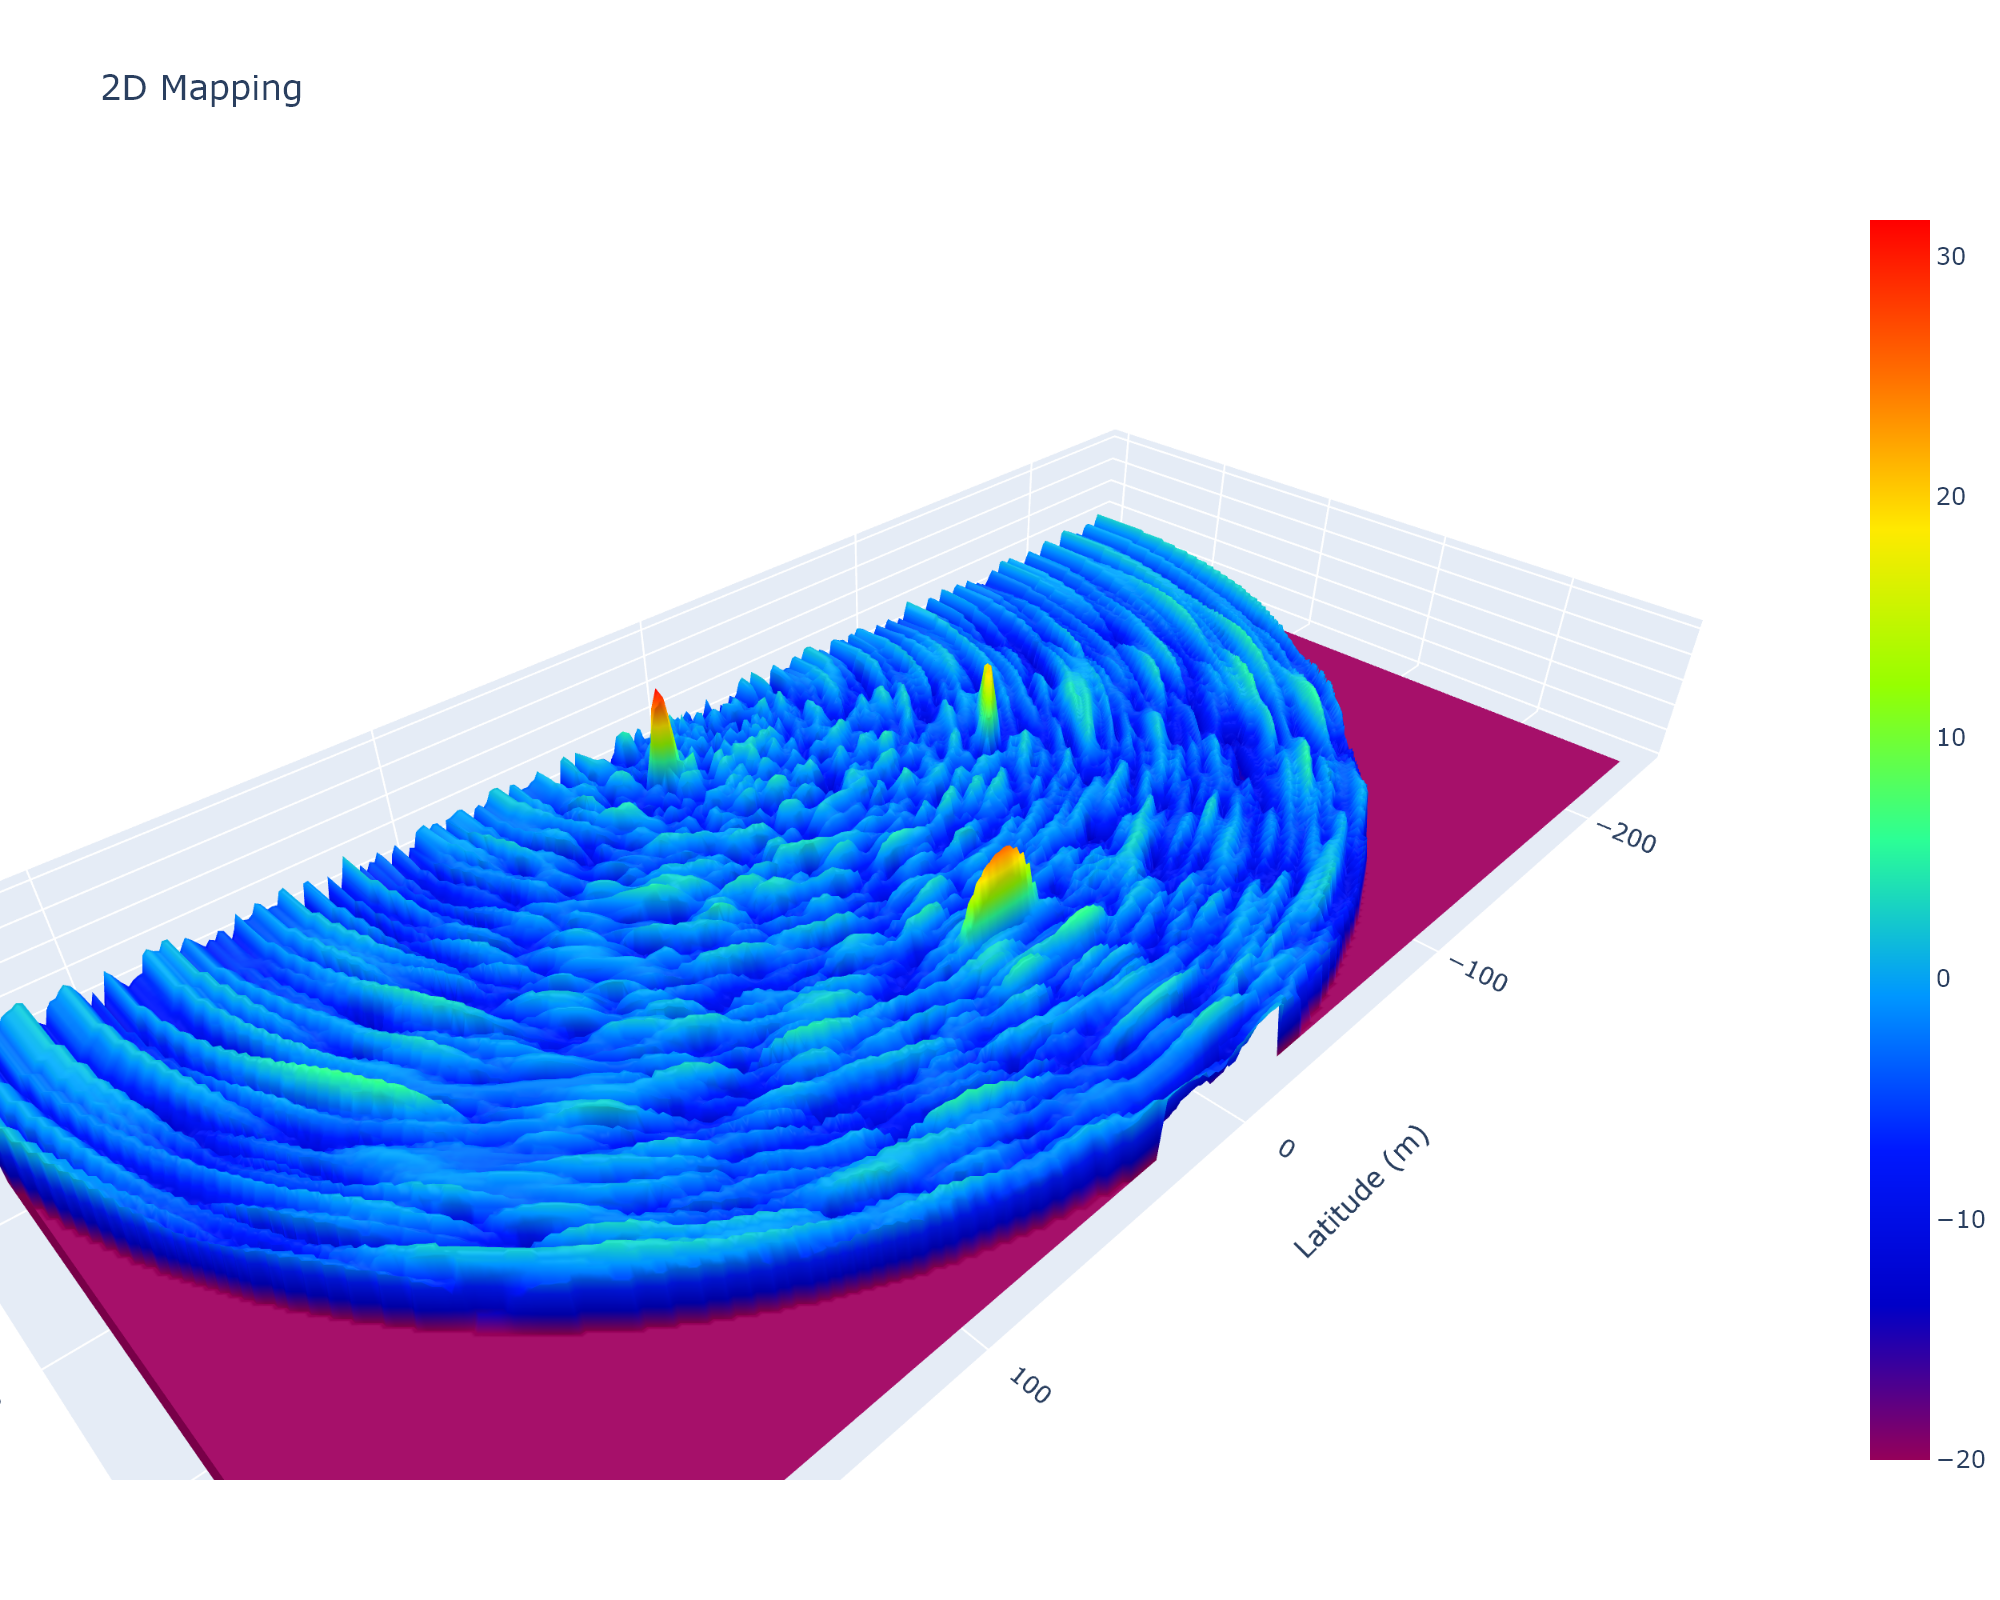

In [18]:
range_axis_la = np.linspace(0,
                            radar.max_range,
                            radar.samples_per_pulse,
                            endpoint=False)
range_axis_lo = np.linspace(-radar.max_range,
                            radar.max_range,
                            radar.samples_per_pulse * 2,
                            endpoint=False)

data = [
    go.Surface(x=range_axis_lo,
               y=range_axis_la,
               z=20 * np.log10(np.abs(map_2d) + 0.1),
               colorscale='Rainbow')
]

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.4, y=1.4, z=1.4)
)

layout = go.Layout(
    title='2D Mapping',
    height=800,
    width=1000,
    scene=dict(
        xaxis=dict(title='Latitude (m)'),
        yaxis=dict(title='Longitude (m)'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='data',
        camera=camera
    ),
    margin=dict(l=0, r=0, b=60, t=100),
)

fig = go.Figure(data=data, layout=layout)
# iplot(fig)
Image(fig.to_image(format='png', scale=2), retina=True)